# Fraud Detection Using Neural Networks

This notebook aims to build and optimize a neural network for fraud detection using grid search for hyperparameter tuning. The key steps include data preprocessing, defining the neural network, training, hyperparameter tuning, and evaluation.


## Data Preprocessing

In [1]:
import numpy as np 
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch

# Read in data
data = pd.read_csv('fraud_oracle.csv')

# One hot encode categorical variables
categorical_cols = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Define target and feature variables
y = data['FraudFound_P'].values
X = data.drop('FraudFound_P', axis=1).values

# Normalize inputs
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Using cuda device for optimal performance
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# Convert to tensors and move to device
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)


## Initial Model Definition
Parameters (Will tune with GridSearch):
- input_dim: Number of input features.
- hidden_dim1=64: Number of neurons in the first hidden layer (default 64).
- hidden_dim2=32: Number of neurons in the second hidden layer (default 32).
- hidden_dim3=16: Number of neurons in the third hidden layer (default 16).
- dropout_rate=0.5: Dropout rate for regularization (default 0.5).

Layers:
- self.layer1: First linear layer.
- self.layer2: Second linear layer.
- self.layer3: Third linear layer.
- self.output: Output linear layer.
- self.dropout: Dropout layer for regularization.

Forward Method:
- Applied ReLU activation to the outputs of the first, second, and third layers to introduce non-linearity.
- Applied dropout after each ReLU activation.
- Applied Sigmoid activation to the output layer to output a probability between 0 and 1 for binary classification.


In [2]:
from torch import nn
from torch import optim

# Define network
class NeuralNetwork1(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32, dropout_rate=0.5):
        super(NeuralNetwork1, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.output = nn.Linear(hidden_dim3, 1)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout(x)
        x = torch.relu(self.layer2(x))
        x = self.dropout(x)
        x = torch.relu(self.layer3(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.output(x))  # Use sigmoid activation for binary classification
        return x

# Instantiate the model
model1 = NeuralNetwork1(X_train.shape[1]).to(device)

# Define the loss criterion
criterion = nn.BCELoss()  # for binary classification

# Define the optimizer
optimizer = optim.Adam(model1.parameters(), lr=1e-3)

In [3]:
# Train the model
epochs = 100
train_losses = []
val_losses = []
for epoch in range(epochs):
    model1.train()
    optimizer.zero_grad()
    outputs = model1(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    model1.eval()
    with torch.no_grad():
        val_outputs = model1(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.5238
Epoch [20/100], Loss: 0.3150
Epoch [30/100], Loss: 0.2526
Epoch [40/100], Loss: 0.2396
Epoch [50/100], Loss: 0.2208
Epoch [60/100], Loss: 0.2155
Epoch [70/100], Loss: 0.2078
Epoch [80/100], Loss: 0.2017
Epoch [90/100], Loss: 0.1908
Epoch [100/100], Loss: 0.1869


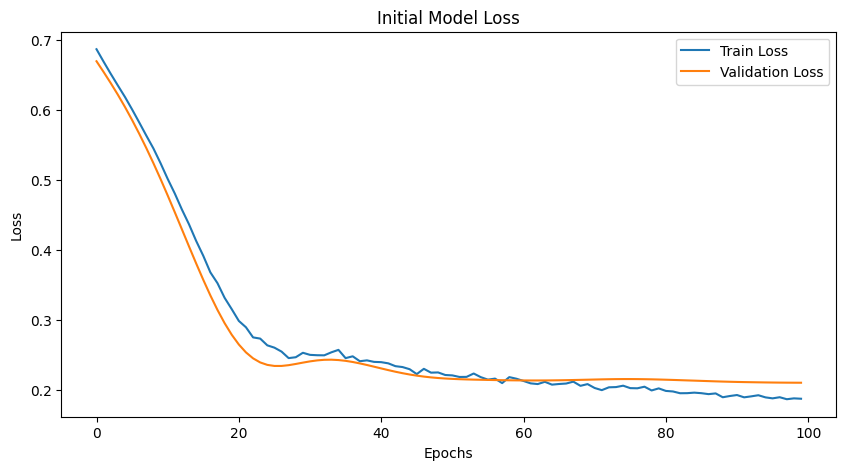

Train Accuracy: 0.9411
Validation Accuracy: 0.9364


In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Plotting the losses
plt.figure(figsize=(10,5))
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Initial Model Loss')
plt.show()

# Evaluate the model
model1.eval()
with torch.no_grad():
    train_outputs = model1(X_train)
    train_preds = (train_outputs > 0.5).float()
    val_outputs = model1(X_val)
    val_preds = (val_outputs > 0.5).float()

train_accuracy = accuracy_score(y_train.cpu().numpy(), train_preds.cpu().numpy())
val_accuracy = accuracy_score(y_val.cpu().numpy(), val_preds.cpu().numpy())

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

With this dataset there is a notable imbalance in the distribution of our target variable across all observations, we will use class weighting to combat this:

In [5]:
from sklearn.utils.class_weight import compute_class_weight

# Class distribution
class_distribution = data['FraudFound_P'].value_counts(normalize=True)
print("Class Distribution:")
print(class_distribution)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train.cpu().numpy().flatten())

# Convert class weights to a tensor and move to the appropriate device
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(f"Class weights: {class_weights}")

Class Distribution:
FraudFound_P
0    0.940143
1    0.059857
Name: proportion, dtype: float64
Class weights: tensor([0.5313, 8.4959], device='cuda:0')


Epoch [10/100], Loss: 1.2930
Epoch [20/100], Loss: 1.2581
Epoch [30/100], Loss: 1.1753
Epoch [40/100], Loss: 1.0692
Epoch [50/100], Loss: 1.0017
Epoch [60/100], Loss: 0.9236
Epoch [70/100], Loss: 0.8632
Epoch [80/100], Loss: 0.8201
Epoch [90/100], Loss: 0.7880
Epoch [100/100], Loss: 0.7418


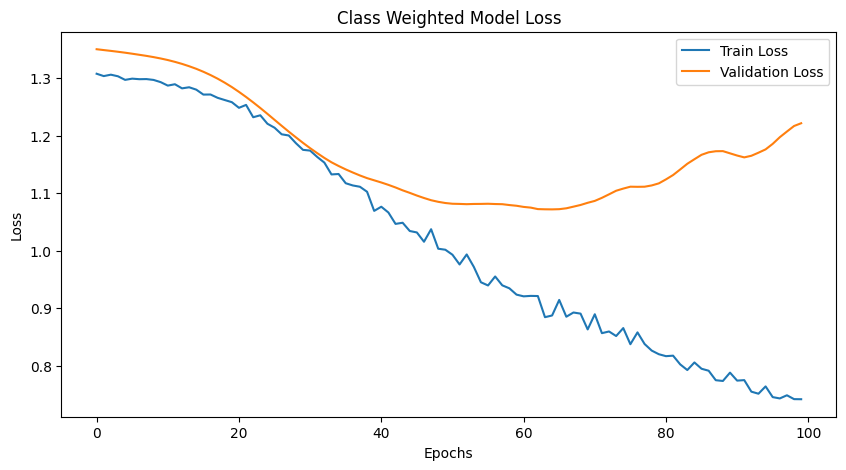

Train Accuracy: 0.8496
Validation Accuracy: 0.8016


In [6]:
# Redefine the network
class NeuralNetwork2(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32, dropout_rate=0.5):
        super(NeuralNetwork2, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.output = nn.Linear(hidden_dim3, 1)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout(x)
        x = torch.relu(self.layer2(x))
        x = self.dropout(x)
        x = torch.relu(self.layer3(x))
        x = self.dropout(x)
        x = self.output(x)  # No sigmoid here because BCEWithLogitsLoss includes it
        return x

# Reinstantiate model
model2 = NeuralNetwork2(X_train.shape[1]).to(device)
optimizer = optim.Adam(model2.parameters(), lr=1e-3)

# Define the loss criterion with class weights
criterion_weighted = nn.BCEWithLogitsLoss(pos_weight=class_weights[1] / class_weights[0])

# Train the model with class weights
train_losses = []
val_losses = []
for epoch in range(epochs):
    model2.train()
    optimizer.zero_grad()
    outputs = model2(X_train)
    loss = criterion_weighted(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    model2.eval()
    with torch.no_grad():
        val_outputs = model2(X_val)
        val_loss = criterion_weighted(val_outputs, y_val)
        val_losses.append(val_loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Plotting the losses
plt.figure(figsize=(10,5))
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Class Weighted Model Loss')
plt.show()

# Evaluate the model
model2.eval()
with torch.no_grad():
    train_outputs = model2(X_train)
    train_preds = (train_outputs > 0.5).float()
    val_outputs = model2(X_val)
    val_preds = (val_outputs > 0.5).float()

train_accuracy = (train_preds == y_train).float().mean()
val_accuracy = (val_preds == y_val).float().mean()
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

Interestingly the validation accuracy decreased and the loss increased with the addition of the weighted classes. Based off of the graph, it also seems we are overfitting to the training data. In order to try to remediate this we will implement focal loss. Focal loss is designed to handle class imbalance by down-weighting easy examples and focusing training on hard negatives, improving performance on imbalanced datasets (https://paperswithcode.com/method/focal-loss).

Epoch [10/100], Loss: 0.0278
Epoch [20/100], Loss: 0.0189
Epoch [30/100], Loss: 0.0178
Epoch [40/100], Loss: 0.0160
Epoch [50/100], Loss: 0.0150
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0134
Epoch [80/100], Loss: 0.0128
Epoch [90/100], Loss: 0.0123
Epoch [100/100], Loss: 0.0116


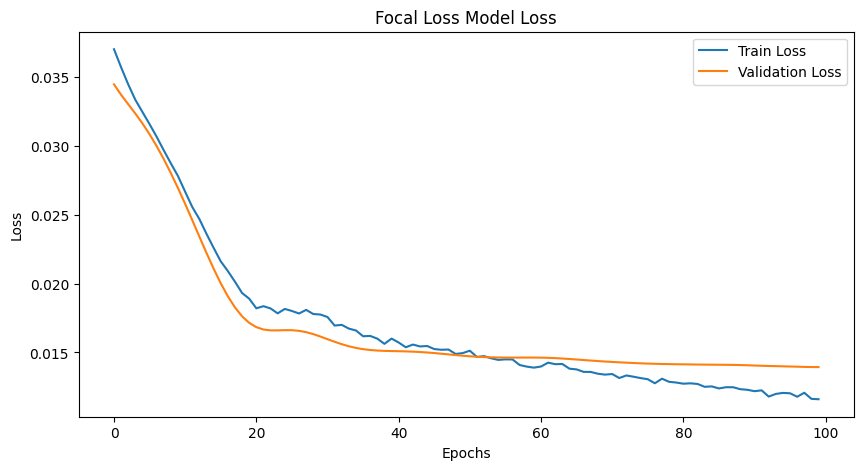

Train Accuracy: 0.9411
Validation Accuracy: 0.9364


In [7]:
import torch.nn.functional as F

# Redefine the network
class NeuralNetwork3(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32, dropout_rate=0.5):
        super(NeuralNetwork3, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.output = nn.Linear(hidden_dim3, 1)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout(x)
        x = torch.relu(self.layer2(x))
        x = self.dropout(x)
        x = torch.relu(self.layer3(x))
        x = self.dropout(x)
        x = self.output(x)  # No sigmoid here because BCEWithLogitsLoss includes it
        return x

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

# Initialize Focal Loss
criterion_focal = FocalLoss(alpha=0.25, gamma=2)

# Re-initialize the model for training with Focal Loss
model3 = NeuralNetwork3(X_train.shape[1]).to(device)
optimizer = optim.Adam(model3.parameters(), lr=1e-3)

# Train the model with Focal Loss
train_losses = []
val_losses = []
for epoch in range(epochs):
    model3.train()
    optimizer.zero_grad()
    outputs = model3(X_train)
    loss = criterion_focal(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    model3.eval()
    with torch.no_grad():
        val_outputs = model3(X_val)
        val_loss = criterion_focal(val_outputs, y_val)
        val_losses.append(val_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

# Plotting the losses
plt.figure(figsize=(10,5))
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Focal Loss Model Loss')
plt.show()

# Evaluate the model
model3.eval()
with torch.no_grad():
    train_outputs = model3(X_train)
    train_preds = (train_outputs > 0.5).float()
    val_outputs = model3(X_val)
    val_preds = (val_outputs > 0.5).float()

train_accuracy = (train_preds == y_train).float().mean()
val_accuracy = (val_preds == y_val).float().mean()
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

[I 2024-06-06 13:06:18,828] A new study created in memory with name: no-name-1bf1203f-a305-4c32-8651-5745843bf0c7
[I 2024-06-06 13:06:18,898] Trial 0 finished with value: 0.01917148381471634 and parameters: {'hidden_dim1': 36, 'hidden_dim2': 29, 'hidden_dim3': 10, 'dropout_rate': 0.4883765937495522, 'lr': 0.00108635732156492}. Best is trial 0 with value: 0.01917148381471634.
[I 2024-06-06 13:06:18,968] Trial 1 finished with value: 0.014335164800286293 and parameters: {'hidden_dim1': 106, 'hidden_dim2': 20, 'hidden_dim3': 17, 'dropout_rate': 0.4745045704501141, 'lr': 0.005997516860883492}. Best is trial 1 with value: 0.014335164800286293.
[I 2024-06-06 13:06:19,036] Trial 2 finished with value: 0.014482008293271065 and parameters: {'hidden_dim1': 112, 'hidden_dim2': 41, 'hidden_dim3': 8, 'dropout_rate': 0.40848600887888975, 'lr': 0.001431353391250119}. Best is trial 1 with value: 0.014335164800286293.
[I 2024-06-06 13:06:19,108] Trial 3 finished with value: 0.014353266917169094 and para

[I 2024-06-06 13:06:21,466] Trial 31 finished with value: 0.014159243553876877 and parameters: {'hidden_dim1': 120, 'hidden_dim2': 56, 'hidden_dim3': 30, 'dropout_rate': 0.2832848731622273, 'lr': 0.003050937363998285}. Best is trial 13 with value: 0.013777187094092369.
[I 2024-06-06 13:06:21,545] Trial 32 finished with value: 0.014658026397228241 and parameters: {'hidden_dim1': 114, 'hidden_dim2': 61, 'hidden_dim3': 32, 'dropout_rate': 0.2884483594078576, 'lr': 0.001409268400203497}. Best is trial 13 with value: 0.013777187094092369.
[I 2024-06-06 13:06:21,632] Trial 33 finished with value: 0.014513570815324783 and parameters: {'hidden_dim1': 122, 'hidden_dim2': 32, 'hidden_dim3': 29, 'dropout_rate': 0.320854903869584, 'lr': 0.0010511083192005829}. Best is trial 13 with value: 0.013777187094092369.
[I 2024-06-06 13:06:21,719] Trial 34 finished with value: 0.014594863168895245 and parameters: {'hidden_dim1': 109, 'hidden_dim2': 51, 'hidden_dim3': 27, 'dropout_rate': 0.3023131780562818, 

Best hyperparameters:  {'hidden_dim1': 127, 'hidden_dim2': 41, 'hidden_dim3': 12, 'dropout_rate': 0.3771893460143221, 'lr': 0.0037637130400742717}
Epoch [10/100], Loss: 0.0178
Epoch [20/100], Loss: 0.0154
Epoch [30/100], Loss: 0.0137
Epoch [40/100], Loss: 0.0126
Epoch [50/100], Loss: 0.0115
Epoch [60/100], Loss: 0.0107
Epoch [70/100], Loss: 0.0101
Epoch [80/100], Loss: 0.0094
Epoch [90/100], Loss: 0.0085
Epoch [100/100], Loss: 0.0079


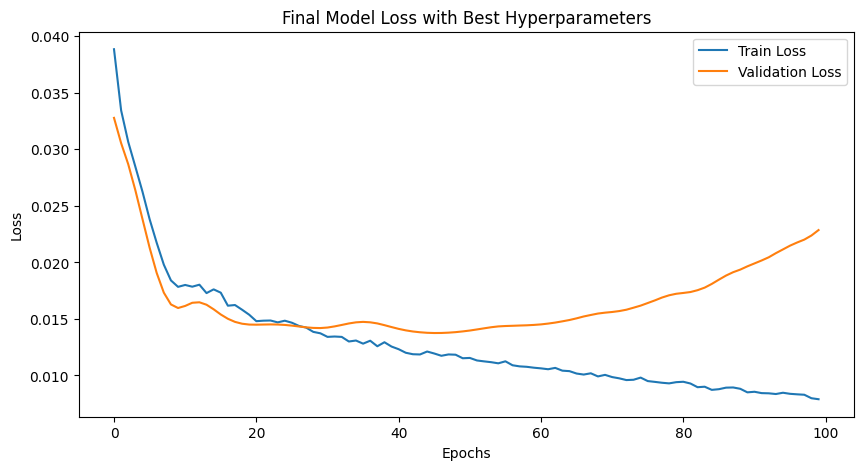

Train Accuracy: 0.9411
Validation Accuracy: 0.9364


In [8]:
import optuna
from torch import optim

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    hidden_dim1 = trial.suggest_int('hidden_dim1', 32, 128)
    hidden_dim2 = trial.suggest_int('hidden_dim2', 16, 64)
    hidden_dim3 = trial.suggest_int('hidden_dim3', 8, 32)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    
    # Instantiate the model
    model = NeuralNetwork3(X_train.shape[1], hidden_dim1, hidden_dim2, hidden_dim3, dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Define the loss criterion
    criterion = FocalLoss(alpha=0.25, gamma=2)

    # Training loop
    epochs = 50
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
    
    return val_loss.item()

# Create study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print best hyperparameters
print('Best hyperparameters: ', study.best_trial.params)


# Train final model with best hyperparameters
best_params = study.best_trial.params
model = NeuralNetwork3(X_train.shape[1], best_params['hidden_dim1'], best_params['hidden_dim2'], best_params['hidden_dim3'], best_params['dropout_rate']).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = FocalLoss(alpha=0.25, gamma=2)
epochs = 50

# Training loop for final model
epochs = 100
train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Plotting the losses for the final model
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Final Model Loss with Best Hyperparameters')
plt.show()

# Evaluate the final model
model.eval()
with torch.no_grad():
    train_outputs = model(X_train)
    train_preds = (train_outputs > 0.5).float()
    val_outputs = model(X_val)
    val_preds = (val_outputs > 0.5).float()

train_accuracy = accuracy_score(y_train.cpu().numpy(), train_preds.cpu().numpy())
val_accuracy = accuracy_score(y_val.cpu().numpy(), val_preds.cpu().numpy())

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

Epoch [10/100], Loss: 0.0196, Val Loss: 0.0158
Epoch [20/100], Loss: 0.0155, Val Loss: 0.0146
Epoch [30/100], Loss: 0.0138, Val Loss: 0.0145
Early stopping at epoch 38


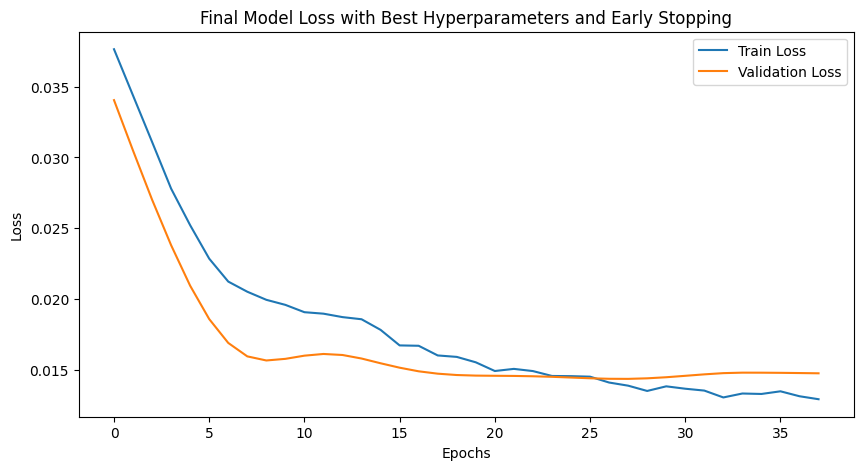

Train Accuracy: 0.9411
Validation Accuracy: 0.9364


In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize the model with best hyperparameters 
best_params = study.best_trial.params
model = NeuralNetwork3(X_train.shape[1], best_params['hidden_dim1'], best_params['hidden_dim2'], best_params['hidden_dim3'], best_params['dropout_rate']).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)
criterion = FocalLoss(alpha=0.25, gamma=2)

# Train the model with early stopping and learning rate scheduler
epochs = 100
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
patience = 10  # Number of epochs to wait before early stopping

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())
    
    # Scheduler step
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Load the best model state
model.load_state_dict(best_model_state)

# Plotting the losses for the final model
plt.figure(figsize=(10,5))
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Final Model Loss with Best Hyperparameters and Early Stopping')
plt.show()

# Evaluate the final model
model.eval()
with torch.no_grad():
    train_outputs = model(X_train)
    train_preds = (train_outputs > 0.5).float()
    val_outputs = model(X_val)
    val_preds = (val_outputs > 0.5).float()

train_accuracy = accuracy_score(y_train.cpu().numpy(), train_preds.cpu().numpy())
val_accuracy = accuracy_score(y_val.cpu().numpy(), val_preds.cpu().numpy())

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')


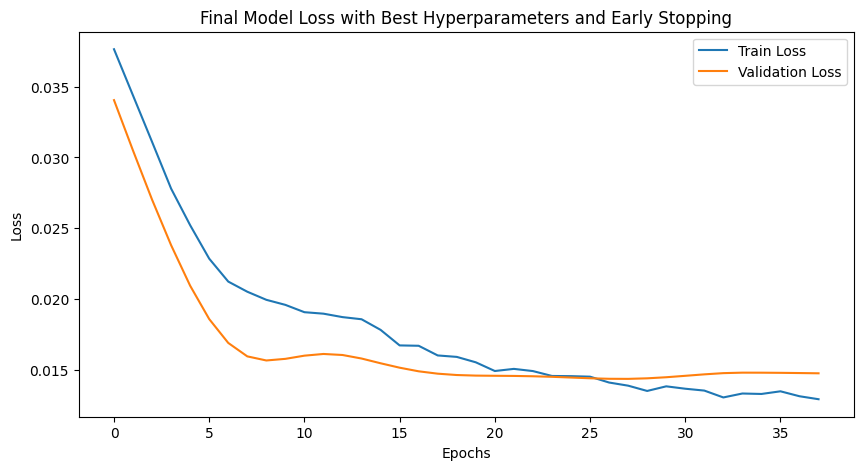

Validation Accuracy: 0.9364
Test Accuracy: 0.9358


In [10]:
# Load the best model state
model.load_state_dict(best_model_state)

# Plotting the losses for the final model
plt.figure(figsize=(10,5))
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Final Model Loss with Best Hyperparameters and Early Stopping')
plt.show()

# Evaluate the final model on the validation set
model.eval()
with torch.no_grad():
    val_outputs = model(X_val)
    val_preds = (val_outputs > 0.5).float()

val_accuracy = accuracy_score(y_val.cpu().numpy(), val_preds.cpu().numpy())

print(f'Validation Accuracy: {val_accuracy:.4f}')

# Evaluate the final model on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_preds = (test_outputs > 0.5).float()

test_accuracy = accuracy_score(y_test.cpu().numpy(), test_preds.cpu().numpy())

print(f'Test Accuracy: {test_accuracy:.4f}')